In [ ]:
!pip install -U ipympl matplotlib numpy

In [36]:

%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from decimal import Decimal
def sci_format(x,lim):
    return '{:.5E}'.format(x)

major_formatter = ScalarFormatter(sci_format)

In [37]:
FOOD_STRENGTHS = {
    "red": 0.001,
    "green": 0.0025,
    "blue": 0.008,
    "black": 0.0225,
    "purple": 0.1050,
    "yellow": 0.1200,
    "white": 0.5,
}


def get_instant_threat_player_count_modifier(player_count):
    minimum_modifier = 125
    maximum_modifier = 250
    player_amount_for_maximum_threat_gain = 20
    gain_per_player = (
        maximum_modifier - minimum_modifier
    ) / player_amount_for_maximum_threat_gain
    m = minimum_modifier + gain_per_player * player_count
    if m > maximum_modifier:
        m = maximum_modifier
    return m


def evo_impact(science, player_count, flask_amount, current_evo, difficulty):
    instant_threat_player_count_modifier = get_instant_threat_player_count_modifier(
        player_count
    )
    food_value = FOOD_STRENGTHS[science] * difficulty
    threat_added = 0
    # Starting evo at 0 produces weird derivatives but whatever i guess
    evo_factor = 0
    evos = [current_evo]
    evo = current_evo
    for x in range(1, flask_amount + 1):
        e2 = (evo_factor * 100) + 1
        diminishing_modifier = (1 / (10 ** (e2 * 0.015))) / (e2 * 0.5)
        evo_gain = food_value * diminishing_modifier
        evo = evo + evo_gain
        if evo <= 1:
            evo_factor = evo
        else:
            evo_factor = 1
        diminishing_modifier = 1 / (0.2 + (e2 * 0.016))
        threat_added = threat_added + (
            food_value * instant_threat_player_count_modifier * diminishing_modifier
        )
        evos.append(evo)

    return evos, threat_added

In [38]:
NEW_FOOD_STRENGTHS = {
    "red": 10,
    "green": 25,
    "blue": 80,
    "black": 225,
    "purple": 1050,
    "yellow": 1200,
    "white": 5000,
}
NEW_difficulties = {
    "itytd": 1,
    "poc": 2,
    "easy": 3,
    "normal": 4,
    "hard": 6,
    "nightmare": 12,
    "fnf": 20,
}


def new_evo_impact(science, player_count, flask_amount, current_evo, difficulty):
    food_slope = NEW_FOOD_STRENGTHS[science] * difficulty
    # new_b = current_evo - food_slope*total_flasks_sent
    # don't need to calculate all these in game but do need to for the plot (also yes there should be a double at evos[0:1] just for plotting)
    evos = [current_evo] + [current_evo + food_slope*x for x in range(flask_amount)]
    threat = (evos[-1] -  evos[0])
    return evos, threat

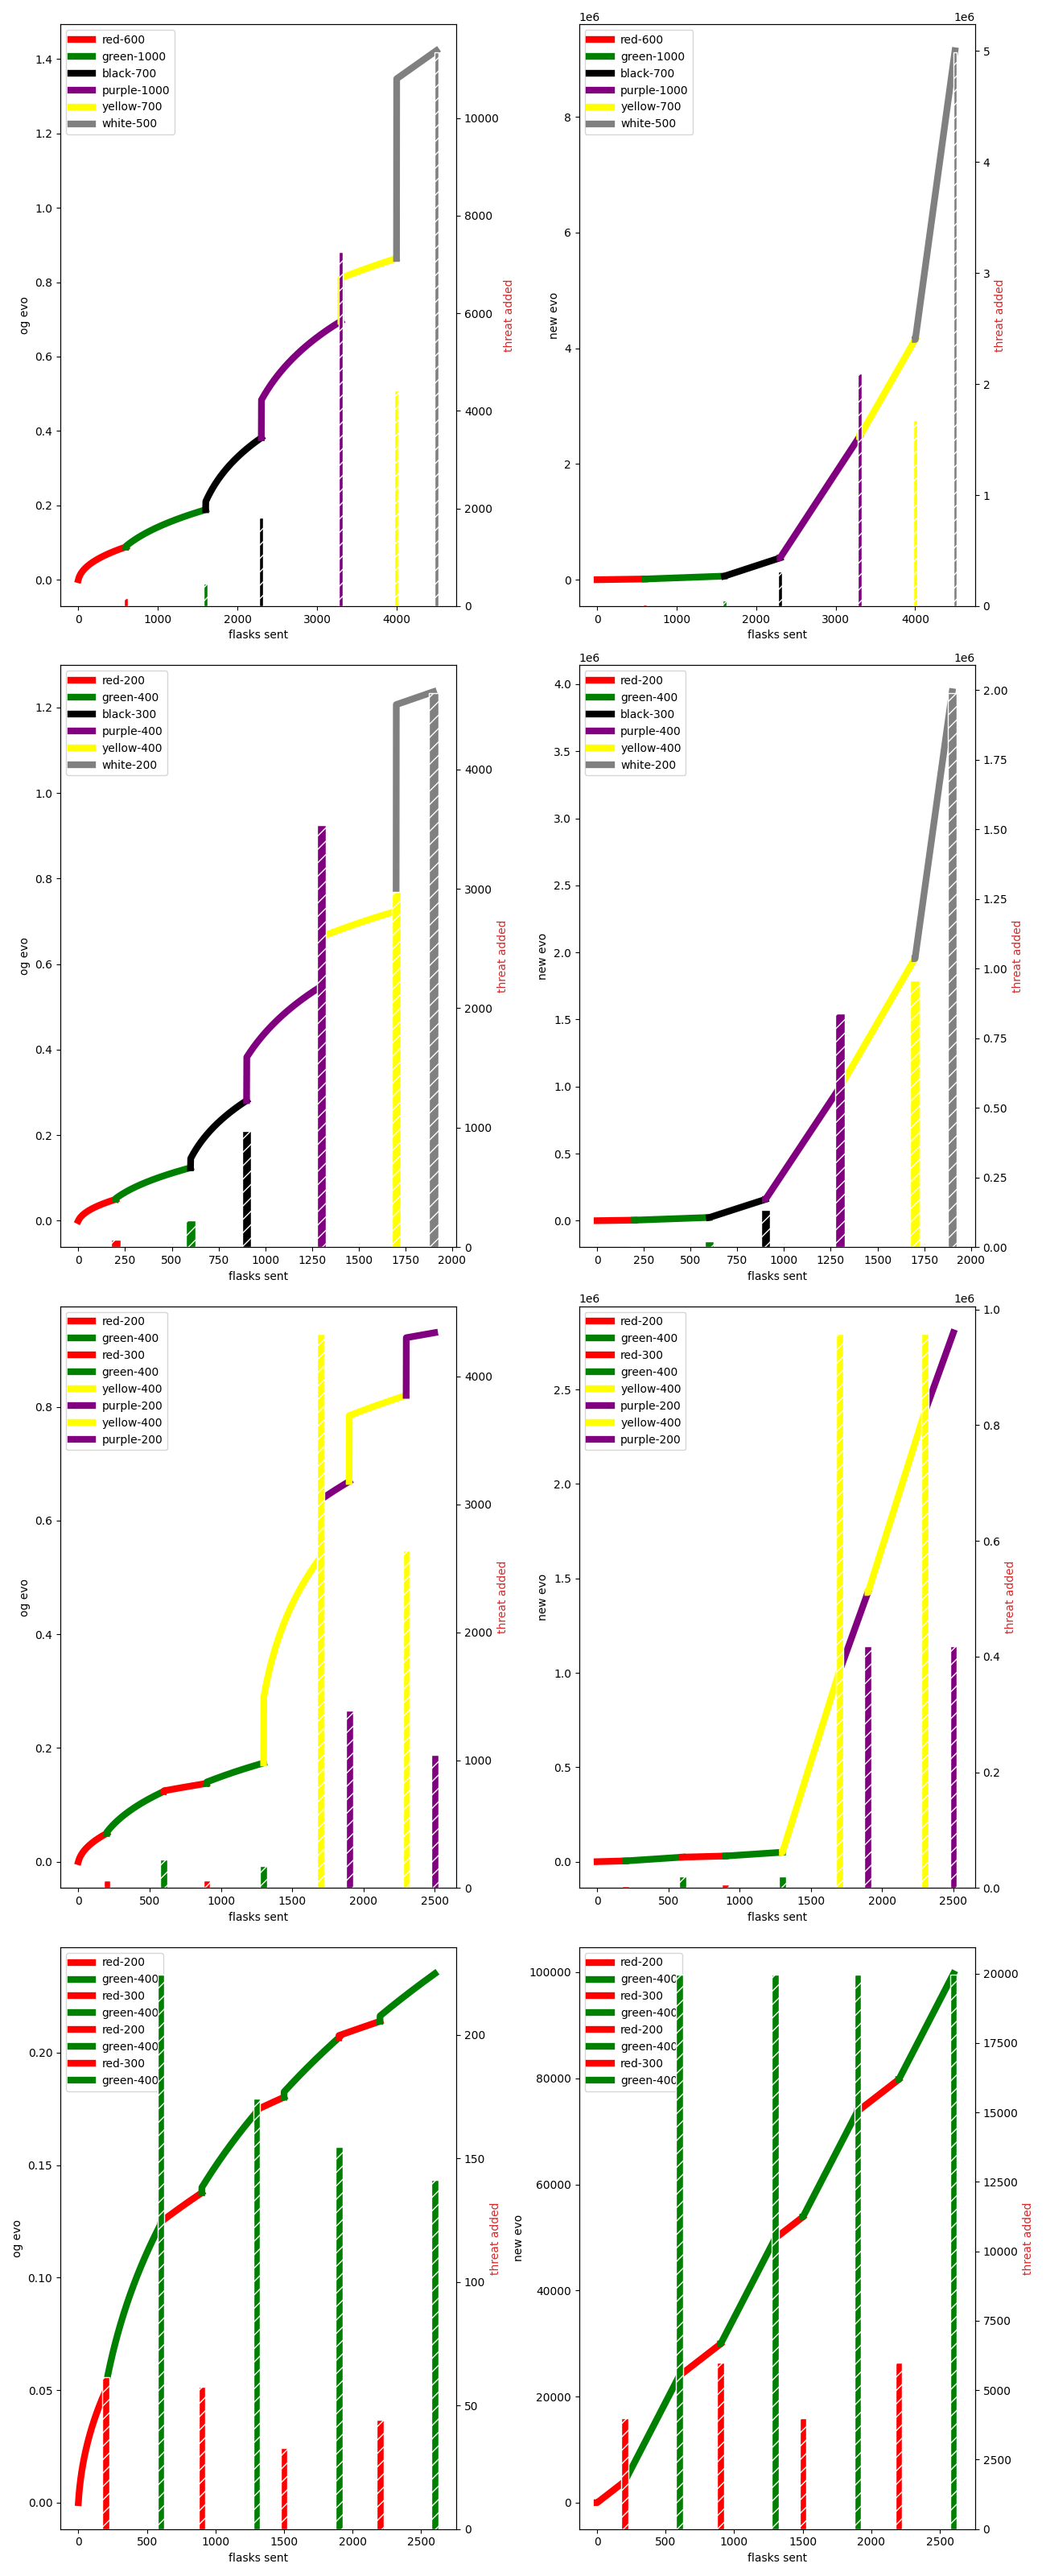

In [40]:
# torun = [
#     (("red", 2000)),
#     (("green", 2000)),
torun = [
    (
        ("red", 600),
        ("green", 1000),
        ("black", 700),
        ("purple", 1000),
        ("yellow", 700),
        ("white", 500),
    ),
    (
        ("red", 200),
        ("green", 400),
        ("black", 300),
        ("purple", 400),
        ("yellow", 400),
        ("white", 200),

    ),
    (
        ("red", 200),
        ("green", 400),
        ("red", 300),
        ("green", 400),
        ("yellow", 400),
        ("purple", 200),
        ("yellow", 400),
        ("purple", 200),
    ),
    (
        ("red", 200),
        ("green", 400),
        ("red", 300),
        ("green", 400),
        ("red", 200),
        ("green", 400),
        ("red", 300),
        ("green", 400),
    )


]
difficulties = {
    "itytd": 0.25,
    "poc": 0.5,
    "easy": 0.75,
    "normal": 1.0,
    "hard": 1.5,
    "nightmare": 3,
    "fnf": 5,
}

fig, axs = plt.subplots(nrows=len(torun), ncols=2, figsize=(13, 8*len(torun)))


player_count = 6
difficulty = difficulties["poc"]
new_difficulty = NEW_difficulties["poc"]
for i, run_schema in enumerate(torun):
    if len(torun) == 1:
        og_ax, new_ax = axs
    else:
        og_ax, new_ax = axs[i]
    og_ax2 = og_ax.twinx()
    og_ax2.patch.set_alpha(0.0)
    new_ax2 = new_ax.twinx()
    new_ax2.patch.set_alpha(0.0)

    evos = []
    colors = []
    start = 1
    new_current_evo = 0
    for science_name, science_count in run_schema:
        label = f"{science_name}-{science_count}"
        if evos:
            current_evo = evos[-1]
            new_current_evo = new_evos[-1]
        else:
            current_evo = 0
            new_current_evo = 0
        # colors += [science_name]*science_count
        this_evo, threat_added = evo_impact(
            science_name, player_count, science_count, current_evo, difficulty
        )
        evos += this_evo
        new_evos, new_threat = new_evo_impact(science_name, player_count, science_count, new_current_evo, new_difficulty)
        plot_start = start - 1
        # print(science_name, science_count,plot_start, start+science_count)

        plot_x = range(plot_start, start + science_count)
        color = science_name
        if science_name == "white":
            color = "grey"
        og_ax.plot(plot_x, this_evo, color=color, label=label, linewidth=6)
        og_ax.set_ylabel("og evo")
        og_ax.set_xlabel("flasks sent")
        new_ax.set_ylabel("new evo")
        new_ax.set_xlabel("flasks sent")


        start += science_count
        og_ax2.bar(start, threat_added, width=50, color=color, label=label, edgecolor="white", hatch="//")
        og_ax2.set_ylabel("threat added", color="tab:red")
        new_ax2.set_ylabel("threat added", color="tab:red")
        new_ax.plot(plot_x, new_evos, color=color, label=label, linewidth=6)
        new_ax2.bar(start, new_threat, width=50, color=color, label=label, edgecolor="white", hatch="//")
        new_ax2.ticklabel_format(axis="y", style="sci", useOffset=False)

        


    og_ax.legend()
    new_ax.legend()
plt.tight_layout()